In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time
import math 

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pyart

import pytz
# import shap
import pickle
import multiprocessing

import cartopy.crs as ccrs

from sklearn.metrics.pairwise import haversine_distances
from math import radians

import netCDF4
from netCDF4 import Dataset

RANDOM_STATE = 42

import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
folder = 'spatial'
node_id = '10004098'
dir_out = '../figures/' + folder + '/'
dir_data = '../data/'
dir_NEXRAD = '/Volumes/Backup Plus/NEXRAD/data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

km_max = 5


In [3]:
# read driving data with NEXRAD, landsat, and humidity
fn0 = dir_data + 'driving_' + node_id + '_NEXRAD_'+str(km_max)+'km_landsat_humidity.csv'
df0 = pd.read_csv(fn0, parse_dates=True, index_col = 'UTC')

In [4]:
# all 33
df0['latitude'].min(),df0['latitude'].max()

(32.9238083333333, 33.2157356666667)

In [5]:
# all -97, which is 360-97 = 263
df0['longitude'].min(),df0['longitude'].max()

(-97.161448, -96.5948276666667)

In [6]:
dir_ozone = '../data/Ozone/'
dir_figure = '../figures/ozone/'

filename_prev = 'OMI-Aura_L3-OMDOAO3e_'
filenames = [filename for filename in os.listdir(dir_ozone) if filename_prev in filename]
filenames = sorted(filenames)

In [39]:
i_lat = 57
i_lon = 263

date_x = []
ozone_y = []
for i, filename in enumerate(filenames):
    date = filename[21:30]
    year = date[:4]
    month = date[-4:-2]
    day = date[-2:]
    print(year, month, day)
    
    date_i = datetime.date(int(year), int(month), int(day))
#     iwant = (df0.index.date == date_i)
        
    try:
        f = Dataset(dir_ozone + filename)
        
        ColumnAmountO3 = f.variables['ColumnAmountO3'][:][i_lat,i_lon]
        
        date_x.append(date_i)
        if type(ColumnAmountO3) == np.float32:
            ozone_y.append(ColumnAmountO3)
        else:
            ozone_y.append(np.nan)
        
#         df0.loc[iwant, 'ColumnAmountO3'] = ColumnAmountO3
    except:
        print('Error on reading file of ', year, month, day)

2019 12 01
2019 12 02
2019 12 03
2019 12 04
2019 12 05
2019 12 06
2019 12 07
2019 12 08
2019 12 09
2019 12 10
2019 12 11
2019 12 12
2019 12 13
2019 12 14
2019 12 15
2019 12 16
2019 12 17
2019 12 18
2019 12 19
2019 12 20
2019 12 21
2019 12 22
2019 12 23
2019 12 24
2019 12 25
2019 12 26
2019 12 27
2019 12 28
2019 12 29
2019 12 30
2019 12 31
2020 01 01
2020 01 02
2020 01 03
2020 01 04
2020 01 05
2020 01 06
2020 01 07
2020 01 08
2020 01 09
2020 01 10
2020 01 11
2020 01 12
2020 01 13
2020 01 14
2020 01 15
2020 01 16
2020 01 17
2020 01 18
2020 01 19
2020 01 20
2020 01 21
2020 01 22
2020 01 23
2020 01 24
2020 01 25
2020 01 26
2020 01 27
2020 01 28
2020 01 29
2020 01 30
2020 01 31
2020 02 01
2020 02 02
2020 02 03
2020 02 04
2020 02 05
Error on reading file of  2020 02 05
2020 02 06
2020 02 07
2020 02 08
2020 02 09
2020 02 10
2020 02 11
2020 02 12
2020 02 13
2020 02 14
2020 02 15
2020 02 16
2020 02 17
2020 02 18
2020 02 19
2020 02 20
2020 02 21
2020 02 22
2020 02 23
2020 02 24
2020 02 25
2020 0

In [40]:
f.variables['lat'][:][i_lat], f.variables['lon'][:][i_lon]-360

(33.0, -97.0)

In [46]:
date2ozone = {}
for i in range(len(date_x)):
    date2ozone[date_x[i]] = ozone_y[i]

In [50]:
df0['ColumnAmountO3'] = np.nan
dates = np.unique(df0.index.date)
for date in dates:
    iwant = (df0.index.date == date)
    df0.loc[iwant, 'ColumnAmountO3'] = date2ozone[date]

In [55]:
fn_merged = dir_data + 'driving_' + node_id + '_NEXRAD_'+str(km_max)+'km_landsat_humidity_O3.csv'
df0.to_csv(fn_merged)

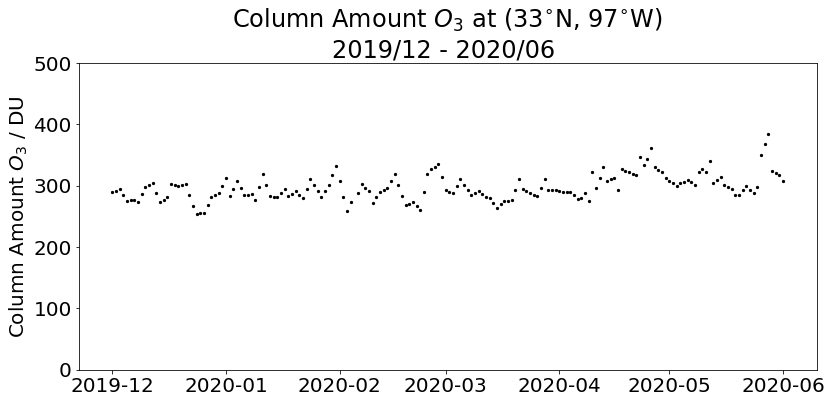

In [88]:
plt.rcParams["figure.figsize"] = (12, 6) # (w, h)
plt.rcParams.update({'font.size': 20})

plt.scatter(date_x, ozone_y, s = 5, c = 'k')
plt.ylim([0,500])

plt.title('Column Amount $O_3$ at ($33^{\circ}$N, $97^{\circ}$W)\n2019/12 - 2020/06 ')
# plt.xlabel('')
plt.ylabel('Column Amount $O_3$ / DU')
plt.tight_layout()
plt.savefig(dir_figure + 'O3_33N_97W_2020.png')
# plt.close()